##Question: Do certain attributes (reach, grip strength on different hold types, etc.) allow climbers to outperform other 
##climbers regardless of the randomly generated wall they are climbing on? AKA, is there an ideal body type for climbing?

In [25]:
import pandas as pd
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import math
import time

These are all of our classes

In [26]:
class Climber:
    """
    Class representing a climber
    """
    def __init__(self, reach, sloper, crimp, jug, position = np.array([5,0]), icon="*"):
        self.reach = reach
        ##Strength (Percent Chance of Sticking a Move To) on Different Types of Holds/Rock
        self.sloper = sloper
        self.crimp = crimp
        self.jug = jug
        ##Location on the wall
        self.position = position
        ##Icon for visualization
        self.icon = icon
        self.heights = []
        
    def make_move(self, holds):
        '''Accepts a list of holds on a wall, will attempt to move to a nearby hold higher up on the wall'''
        reachable = []
        for hold in holds:
            if self.reach > np.linalg.norm(self.position-hold.coords) and self.position[1]-hold.coords[1] < 0 and np.linalg.norm(self.position - hold.coords) != 0:
                reachable.append(hold)
        reached = []
        reached_dists = []
        for hold in reachable:
            if hold.type == 'jug':
                if random.random() <= self.jug:
                    reached.append(hold.coords)
            elif hold.type == 'sloper':
                if random.random() <= self.sloper:
                    reached.append(hold.coords)
            elif hold.type == 'crimp':
                if random.random() <= self.crimp:
                    reached.append(hold.coords)
        if not reached:
            return 'fall'
        
        for i in reached:
            x = math.dist(self.position, i)
            reached_dists.append(x)
        self.position = reached[np.argmin(reached_dists)]
        
        return 'stuck'
    
    def set_position(self, position = np.array([5, 0])):
        '''Sets position, can be used to reset after climbing a wall'''
        self.position = np.array(position)
        
        
    def average_h(self):
        return float(sum(self.heights))/len(self.heights)

In [27]:
class Hold:
    def __init__(self, coords, type_):
        self.coords = np.array(coords)
        self.type = type_

In [28]:
class Cell:
    """
    Class representing one 10 by 10 cell on a wall
    Attributes:
    slopers - number of sloper holds
    crimps - number of crimp holds
    jugs - number of jug holds
    height - height of the cell along the wall. should be multiple of 10
    holds - array of hold objects in the cell
    
    methods:
    show(): plots cell
    """
    def __init__(self, slopers, crimps, jugs, height = 0):
        ##Number of Each Type of Hold/Rock
        self.slopers = slopers
        self.crimps = crimps
        self.jugs = jugs
        self.num_cells = 1
        ##Setting Coordinates of the Holds
        self.total_holds = self.slopers + self.crimps + self.jugs
        self.x = np.random.randint(1, 11, size = self.total_holds)
        self.y = np.random.randint(1, 11, size = self.total_holds)
        self.holds = []
        self.hold_types = []
        for i in range(slopers):
            new_hold = Hold([self.x[i], self.y[i]+height], "sloper")
            self.holds.append(new_hold)
            self.hold_types.append("sloper")
        for j in range(crimps):
            new_hold = Hold([self.x[j+i], self.y[j+i]+height], "crimp")
            self.holds.append(new_hold)
            self.hold_types.append("crimp")
        for k in range(jugs):
            new_hold = Hold([self.x[k+j+i], self.y[k+j+i]+height], "jug")
            self.holds.append(new_hold)       
            self.hold_types.append("jug")
        
    def show(self):
        '''Plots cell with all holds'''
        sns.scatterplot(x = self.x,y = self.y, hue = self.hold_types, style = self.holds, palette = 'bright', s = 100)
        plt.axis([0,10, 0, 10])
        plt.show()
    


In [37]:
class Wall:
    """
    Class representing a whole wall, made up of cells
    """
    def __init__(self, smallwall, cell):
        ##Number of Each Type of Hold/Rock
        self.slopers = smallwall.slopers + cell.slopers
        self.crimps = smallwall.crimps + cell.crimps
        self.jugs = smallwall.jugs + cell.jugs
        self.num_cells = smallwall.num_cells + cell.num_cells
        self.hold_types = smallwall.hold_types + cell.hold_types
        ##Setting Coordinates of the Holds
        self.total_holds = self.slopers + self.crimps + self.jugs
        self.x = np.concatenate((smallwall.x, cell.x))
        self.y = np.concatenate((smallwall.y, cell.y + np.repeat(10*(self.num_cells-1), len(cell.y))))
        self.holds = np.concatenate((smallwall.holds, cell.holds))
        self.hold_cords = []
        for i in range(self.total_holds):
            self.hold_cords.append([self.x[i], self.y[i]])
        
    def show(self, show_scale = 1, title = 'Rock Wall'):
        '''Plots Wall with all holds shown'''
        fig = plt.figure(figsize = (10*show_scale, len(self.x)*show_scale))
        sns.scatterplot(x = self.x,y = self.y, hue = self.hold_types, style = self.hold_types, palette = 'bright', s = 100)
        plt.axis([0,10, 0, 10*self.num_cells])
        plt.title(title)
        plt.show()
        
    def run_wall(self, climber):
        '''Takes in a climber object and simulates the climber attempting to climb the wall. 
        Returns a list of all points the holder occupied during their path'''
        path = []
        status = "stuck"
        while status == "stuck":
            path.append(climber.position)
            status = climber.make_move(self.holds)
        climber.set_position()
        return path
    
#     def plot_path(self, path, show_scale = 1, title = 'Rock Wall'):
#         '''Plots wall along with climber path for the given path'''
#         sns.scatterplot(x = self.x,y = self.y, hue = self.hold_types, style = self.hold_types, palette = 'bright', s = 100)
#         plt.axis([0,10, 0, 10*self.num_cells])
#         plt.title(title)
        
#         for i in range(len(path)):
#             part_path = path[0:i]
#             plt.plot(*zip(*part_path))
#             plt.pause(0.05)
#         plt.show()
    
    def plot_path(self, path, show_scale = 1, title = 'Rock Wall'):
        '''Plots wall along with climber path for the given path'''
        part_path = path[0:2]
        
        plt.ion()
        
        fig, ax = plt.subplots(figsize = (10*show_scale, len(self.x)*show_scale))
        line, = ax.plot([], [], 'g', lw = 2)
        
        sns.scatterplot(x = self.x,y = self.y, hue = self.hold_types, style = self.hold_types, palette = 'bright', s = 100)
        ax.set_xlim([0, 10])
        ax.set_ylim([0, 10*self.num_cells])
        ax.set_title(title)
        
        
        for i in range(len(path)):
            x, y = path[i]
            line.set_data(path[:i+1, 0], path[:i+1, 1])
            plt.draw()
            time.sleep(0.1)

        plt.show()
        
#         def update(i):
#             x, y = path[:i+1].T
#             line.set_data(x, y)

#         ani = animation.FuncAnimation(fig, update, frames=len(path), interval=100, repeat=False)

#         plt.show()
        
#         for i in range(len(path)):
#             x, y = path[i]
            
#             line.set_xdata(list(line.get_xdata())+[x])
#             line.set_ydata(list(line.get_ydata())+[y])

#             fig.canvas.draw()
#             fig.canvas.flush_events()
#             time.sleep(1)

Below are all of the functions we use

In [38]:
##Notes
##We decided two holds being placed in the same location is appropriate given that many climbing gyms will drill one hold on 
##top of another to make the move easier/more attainable for different climbing types

In [39]:
def create_wall(cells, slopers, crimps, jugs):
    '''Creates a wall with given specifications'''
    cell1 = Cell(slopers, crimps, jugs)
    cell2 = Cell(slopers, crimps, jugs, 10)
    smallwall = Wall(cell1,cell2)
    for i in range(cells-2):
        cell1 = cell(slopers, crimps, jugs, (i+2)*10)
        smallwall = wall(smallwall, cell1)
    return smallwall

In [40]:
def create_climbers(n, reach, sloper, crimp, jug):
    '''Each input other than n is a list of 2 numbers, a min and a max for that attribute
        Creates a list of n climbers with attributes '''
    climber_list = []
    for i in range(n):
        reach1 = random.uniform(reach[0], reach[1])
        sloper1 = random.uniform(sloper[0], sloper[1])
        crimp1 = random.uniform(crimp[0], crimp[1])
        jug1 = random.uniform(jug[0], jug[1])
        climber1 = Climber(reach1, sloper1, crimp1, jug1)
        climber_list.append(climber1)
    return climber_list

In [41]:
def simulate(climbers, walls):
    '''Takes in a list of climbers and walls, runs all climbers on all walls, keeping track of how high they made it'''
    for wall in walls:
        for climber in climbers:
            path = wall.run_wall(climber)
            height = path[-1][1]
            climber.heights.append(height)
            

Example showing our code in action (one wall, one climber, plot path)

TypeError: list indices must be integers or slices, not tuple

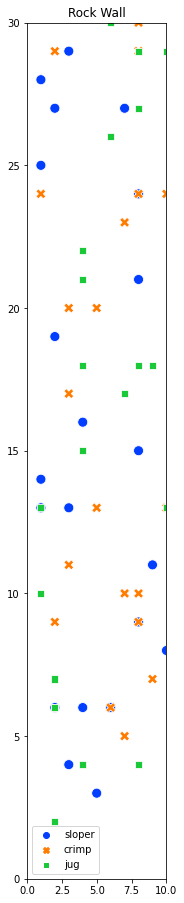

In [42]:
cell1 = Cell(7,7,7)
cell2 = Cell(7,7,7,10)
cell3 = Cell(7,7,7,20)
wall1 = Wall(cell1, cell2)
wall1 = Wall(wall1, cell3)
#plt.legend
climber1 = Climber(5, 0.8, 0.8, 0.8)
#wall1.show()
wall1.plot_path(wall1.run_wall(climber1), show_scale = 0.25)

In [36]:
wall1.run_wall(climber1)

[array([5, 0]),
 array([6, 3]),
 array([6, 4]),
 array([5, 6]),
 array([5, 7]),
 array([3, 9]),
 array([ 3, 10]),
 array([ 1, 12]),
 array([ 1, 13]),
 array([ 1, 14]),
 array([ 2, 15]),
 array([ 2, 17]),
 array([ 4, 19]),
 array([ 6, 20]),
 array([ 7, 21]),
 array([ 8, 22]),
 array([ 9, 23])]

Simulation with 100 Climbers, 20 walls (generating data)

In [183]:
walls = []
for i in range(10):
    walls.append(create_wall(10,7,7,7))
climbers = create_climbers(10,[6,8],[0.5,0.8],[0.5,0.8],[0.5,0.8])
simulate(climbers, walls)
for climber in climbers:
    print(climber.average_h())


93.1
86.1
71.6
53.9
70.3
86.8
34.9
64.9
36.3
91.1


Data Analysis Code